# **Weak Instruments**

**Author:**
[Anthony Strittmatter](http://www.anthonystrittmatter.com)

In the following, we use a Monte-Carlo simulation to illustrate the bias of OLS under violations of the exclusion restriction and the vulnerability of IV when the first stage is weak. Because the data is artificial, we have control over the data generating process (DGP). Accordingly, we know the true underlying data model. 

## Load Packages

In [1]:
########################  Load Packages  ########################

# Load packages
library(AER) # Used for IV regression
library(ggplot2) # Used for density plot
options(warn=-1) # supress warnings

print('All packages successfully installed and loaded.')

Loading required package: car

Loading required package: carData

Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: survival



[1] "All packages successfully installed and loaded."


## Select Parameters for Data Generating Process (DGP)

In [2]:
########################  Tuning Parameter Selection  ########################

N = 50 # Select sample size

beta = 0.5 # Specify size of effect of D on Y

bias_ols = 0.2 # Specify the size of the OLS bias

F = 2 # Specify first stage F-statistic

replications = 1000 # Select number of replications for Monte Carlo

sigma_Z = 1 # Specify noise of the DGP

print('Tuning parameters selected.')

[1] "Tuning parameters selected."


## First Stage Regresion

We generate one random draw from our DGP and test the power of the first stage.

In [3]:
## Data Generating Process ##

set.seed(12345689) # Set starting values

# Generate Instrument
Z <- rnorm(n=N, mean = 0, sd =sigma_Z)  
    
# Generate Treatment
sigma_D = sqrt((F+N-2)*sigma_Z^2/F -sigma_Z^2) # Specify Va
v <- rnorm(n=N, mean = 0, sd =sigma_D)
D <- Z + v

# Generate Outcome
frac  = bias_ols*(sigma_Z^2+sigma_D^2)/sigma_D^2
Y = beta*D + frac*v + rnorm(n=N)

## First Stage Regression ##

#OLS regression
first_stage <- lm(D ~ Z , data = as.data.frame(cbind(D,Z)))
summary(first_stage)
    
# Empirical F-statistic
F_emp = (N-2)*(first_stage$coefficient[2]^2*var(Z)/(var(D)))/(1-(first_stage$coefficient[2]^2*var(Z)/var(D)))
print(paste0("Empirical F-statistic: ",round(F_emp, digits =2)))

# Population F-statistic
Ftrue = (N-2)*(sigma_Z^2/(sigma_D^2+sigma_Z^2))/(1-(sigma_Z^2/(sigma_D^2+sigma_Z^2)))
print(paste0("True F-statistic: ",round(Ftrue, digits =2)))


Call:
lm(formula = D ~ Z, data = as.data.frame(cbind(D, Z)))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.168828 -0.041778 -0.001576  0.038499  0.166469 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.009851   0.010061   0.979    0.332    
Z           0.996618   0.009848 101.198   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07107 on 48 degrees of freedom
Multiple R-squared:  0.9953,	Adjusted R-squared:  0.9952 
F-statistic: 1.024e+04 on 1 and 48 DF,  p-value: < 2.2e-16


[1] "Empirical F-statistic: 10241.13"
[1] "True F-statistic: 10000"


## OLS Regression of Y on D

In [4]:
## OLS ##

ols <- lm(Y ~ D, data = as.data.frame(cbind(Y,D)))
summary(ols) 


Call:
lm(formula = Y ~ D, data = as.data.frame(cbind(Y, D)))

Residuals:
   Min     1Q Median     3Q    Max 
-5.965 -2.238 -0.054  1.930  7.606 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   0.3899     0.4301   0.907    0.369
D             0.6271     0.4216   1.487    0.143

Residual standard error: 3.039 on 48 degrees of freedom
Multiple R-squared:  0.04406,	Adjusted R-squared:  0.02415 
F-statistic: 2.212 on 1 and 48 DF,  p-value: 0.1434


## IV Regression of Y on D

In [5]:
## IV ##

iv <- ivreg(formula = Y ~ D | Z, data = as.data.frame(cbind(Y,D,Z)))
summary(iv)


Call:
ivreg(formula = Y ~ D | Z, data = as.data.frame(cbind(Y, D, Z)))

Residuals:
    Min      1Q  Median      3Q     Max 
-6.2633 -2.2207 -0.1935  1.7512  7.7202 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   0.3829     0.4310   0.888    0.379
D             0.4341     0.4235   1.025    0.310

Residual standard error: 3.046 on 48 degrees of freedom
Multiple R-Squared: 0.03989,	Adjusted R-squared: 0.01989 
Wald test: 1.051 on 1 and 48 DF,  p-value: 0.3105 


## Monte Carlo Simulation

Up to now we generated only one random draw of our DGP and estimated the parameters of interst in thi sample. But are the biases that we found systematic or did they occur just by chance? To answer this, we take many independent random draws of our DGP and estimate the parameters of interest in each sample. Afterwards, we can compare the distributions of the parameters, which gives us information about the finite sample properties of the estimators.

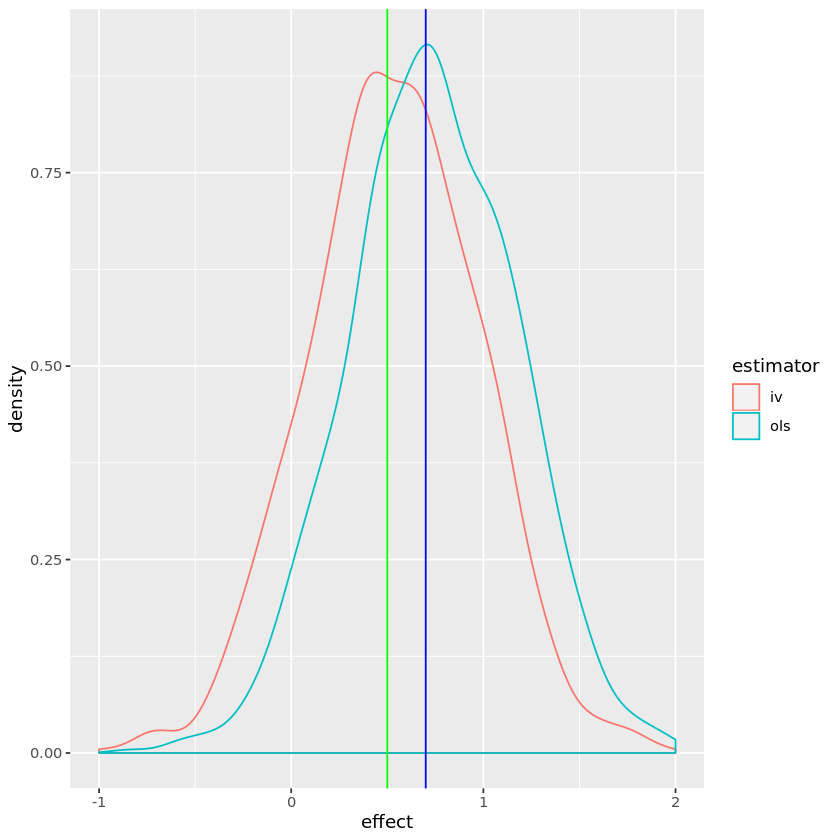

In [6]:
####### Monte Carlo Simulation #######

set.seed(123456789) # Set starting value

# Generate matrix to store results
effect <- matrix(NA, nrow = replications, ncol = 2)
colnames(effect) <- c("ols", "iv")

for (r in c(1:replications)) {
    
    ## Data Generating Process ##
    
    # Generate Instrument
    Z <- rnorm(n=N, mean = 0, sd =sigma_Z)  
    
    # Generate Treatment
    sigma_D = sqrt((F+N-2)*sigma_Z/F -sigma_Z) 
    v <- rnorm(n=N, mean = 0, sd =sigma_D)
    D <-  Z + v
    
    # Generate Outcome
    frac  = bias_ols*(sigma_Z^2+sigma_D^2)/sigma_D^2
    Y = beta*D + frac*v + rnorm(n=N)
    
    ## Estimation ##
    
    # OLS
    ols <- lm(Y ~ D, data = as.data.frame(cbind(Y,D)))
    effect[r,1] <- ols$coefficients[2] 
    
    # IV
    iv <- ivreg(formula = Y ~ D | Z, data = as.data.frame(cbind(Y,D,Z)))
    effect[r,2] <-iv$coefficients[2] 
}

# Density plot
dat <- data.frame(estimator = factor(rep(c("ols","iv"), each=replications)),
                effect = rbind(as.matrix(effect[,1]),as.matrix(effect[,2])))
ggplot(dat, aes(x=effect, colour=estimator)) + geom_density() + xlim((beta-1.5),(beta+1.5)) +
                geom_vline(xintercept = beta, color = "green") +
                geom_vline(xintercept = (beta+bias_ols), color = "blue")


Now go back to the snipplet were we specified the tuning parameters. You can play around with the tuning parameters and look at the finite sample performance of OLS and IV. For example, how does the finite sample performance of IV change when we increase the power of the first stage? Let's set $F= 10000$